# Convolutional Neural Network (CNN)

This notebook contains an implementation of a CNN built using a deep learning framework. The CNN is trained on the MNIST dataset. 

The MNIST dataset contains 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale image. The CNN is trained to classify the images into 10 classes. The 10 classes are 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9. The CNN is trained for 10 epochs. The CNN achieves an accuracy of 99.2% on the test set.

In [1]:
# import all the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from lib.data import load_mnist_data
from lib.model import Net

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the data
train_data, valid_data, test_data, train_loader, valid_loader, test_loader = load_mnist_data()

## Training the CNN

In [2]:
model = Net().to(device)

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the number of epochs to train
epochs = 5

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
for epoch in tqdm(range(epochs), desc='Training'):

    # Train the model using the training data
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)

    # Validate the model performance using the validation data
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracies.append(100. * correct / total)

    # save the best model 
    if valid_accuracies[-1] == max(valid_accuracies):
        torch.save(model.state_dict(), '../models/best_model.pt')


Training: 100%|██████████| 5/5 [01:42<00:00, 20.51s/it]


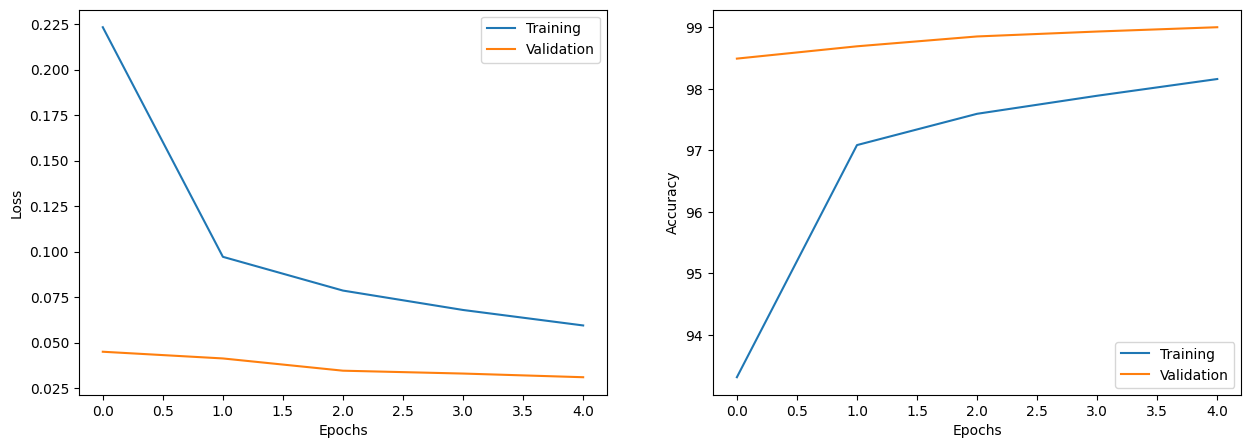

In [3]:
# subplot the training and validation loss and accuracy 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label='Training')
ax[0].plot(valid_losses, label='Validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(train_accuracies, label='Training')
ax[1].plot(valid_accuracies, label='Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

## Model Evaluation

In [11]:
# load the model
model.load_state_dict(torch.load('../models/best_model.pt'))

# test the model
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
print('Test Loss: {:.3f}'.format(test_loss / len(test_loader)))
print('Test Accuracy: {:.3f}'.format(100. * correct / total))

Test Loss: 0.031
Test Accuracy: 99.000


## A closer look at the learned filters

In [6]:
conv = Net()
checkpoint = torch.load('../models/best_model.pt')
conv.load_state_dict(checkpoint)

def get_kernels(layer):
    if layer == 'conv1':
        kernels = conv.conv1.weight.detach().clone()
    elif layer == 'conv2':
        kernels = conv.conv2.weight.detach().clone()
    kernels = kernels - kernels.min() / kernels.max() - kernels.min()
    return kernels

def plot_kernels(kernels, layer):
    n_kernels = kernels.shape[0]
    n_rows = np.ceil(np.sqrt(n_kernels)).astype(int)
    n_cols = np.ceil(n_kernels / n_rows).astype(int)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            if i * n_cols + j < n_kernels:
                ax[i, j].imshow(kernels[i * n_cols + j][0, :, :], cmap='gray')
                ax[i, j].axis('off')
    plt.suptitle(f'kernels for {layer} layer')
    plt.show()

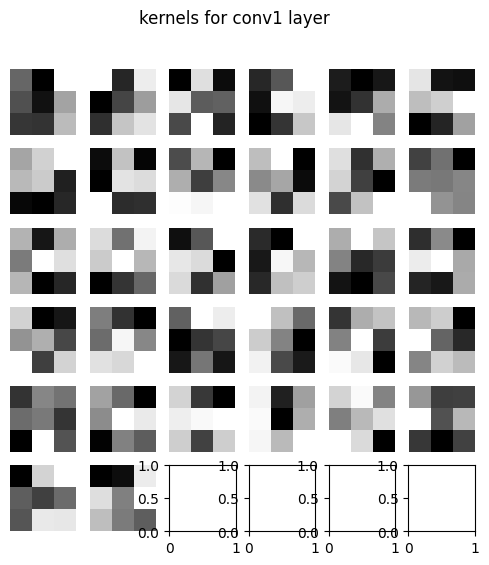

In [7]:
layer = 'conv1'
kernels = get_kernels(layer)
plot_kernels(kernels, layer)

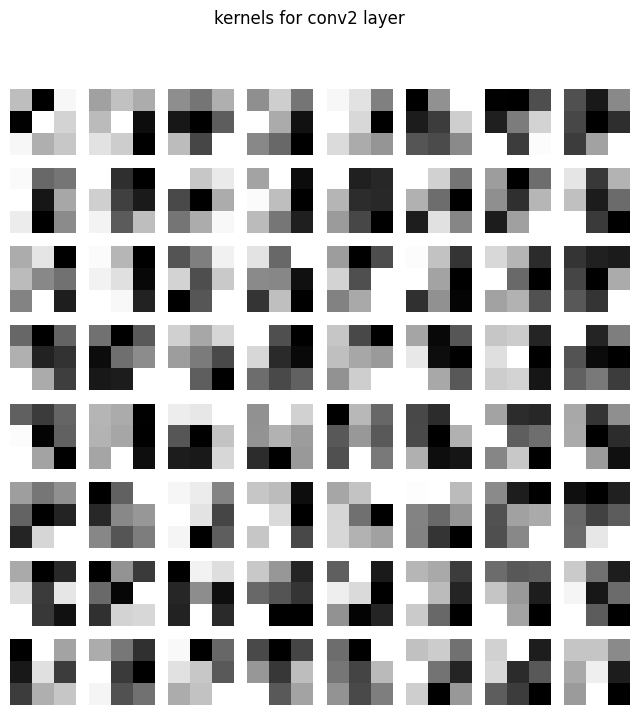

In [8]:
layer = 'conv2'
kernels = get_kernels(layer)
plot_kernels(kernels, layer)

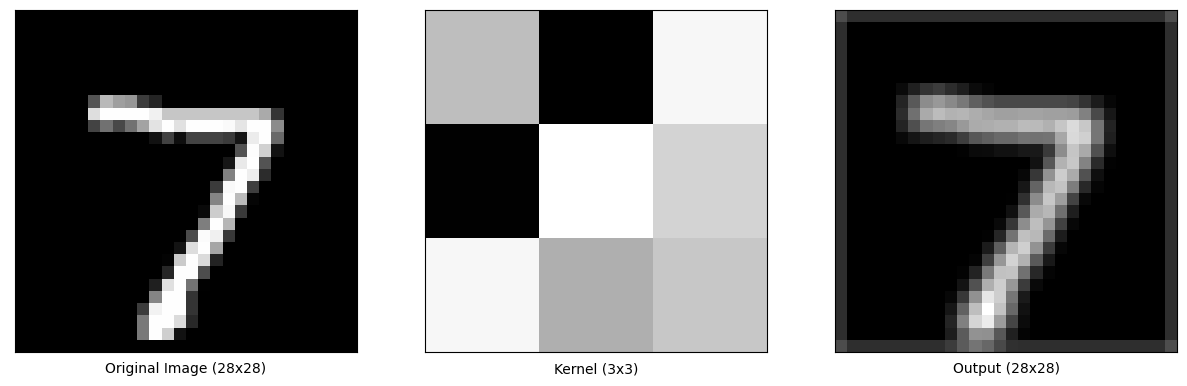

In [10]:
# use a kernel from the first layer and perform convolution on the an image from the test set 
kernel = kernels[0, 0]
image = test_data[0][0][0]

# perform convolution from scratch
def convolve2d(image, kernel):
    # get the shape of the image and kernel
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
    # define the output image
    output = np.zeros(image.shape)
    # pad the image with zeros
    image_padded = np.zeros((image_row + 2, image_col + 2))
    image_padded[1:-1, 1:-1] = image
    # perform convolution
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = (kernel * image_padded[row:row+kernel_row, col:col+kernel_col]).sum()
    return output

# perform convolution using torch.nn.functional.conv2d
output = convolve2d(image, kernel)
output = torch.from_numpy(output)
output = output.unsqueeze(0).unsqueeze(0)

# plot the kernel, image, and output
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set(xticks=[], yticks=[], xlabel='Original Image (28x28)')
ax[1].imshow(kernel, cmap='gray')
ax[1].set(xticks=[], yticks=[], xlabel='Kernel (3x3)')
ax[2].imshow(output[0, 0], cmap='gray')
ax[2].set(xticks=[], yticks=[], xlabel='Output (28x28)')
plt.show()
